# Degree project
This python notebook contains the experiments for Mark Bergrahm's degree project at KTH. The focus of this notebook is to compare attributive explanation methods on a partially trained model at multiple early stops. The high performant base setup and tuning is adapted from a leaderboard entry for imagenette 128px 5 epochs (https://github.com/radekosmulski/imagenette-LB-entry/blob/main/imagenette_with_pytorch.ipynb)

## Imports and globals
Imports, downloading data and global vars

In [1]:
# Base imports
import os
import re
import gc # Manual garbage collection to make available maximum amount of memory for training after each explanation iteration.
# import random
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# import torchvision.models as models

import numpy as np
# import pandas as pd

import matplotlib.pyplot as plt
from fastai.basics import *
from fastai.vision.models.xresnet import *
from fastai.callback.schedule import combined_cos

In [2]:
# Custom attributive explanation methods
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel, GradientShap, Lime
# from explainable_ai_image_measures import Measures      # Summary statistics IAUC, DAUC and IROF
from helper_funcs import AverageMeter, accuracy, generate_attributions, sum_explanations, average_summary_scores, running_stats

In [3]:
START_TEST_FREQUENCY = 10 # Start testing after this many training samples
STEP_TEST_FREQUENCY = 10 # Increase the number of training samples between testing with this amount

BATCH_SIZE = 128
EXPLANATION_BATCH_SIZE = 4 # 32 for van, smo, shap & lime, 4 for ig
NUM_WORKERS = 4
LR = 8e-3
lr_schedule = combined_cos(0.75, LR, LR, LR/100000)

WEIGHT_DECAY=1e-2
NUM_EPOCHS=10

SUPERPIXEL_SIZE = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed for deterministic results
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
print(device)

cuda


In [5]:
# # Source code for summary statistics, https://github.com/meier-johannes94/ExplainableAIImageMeasures/blob/main/explainable_ai_image_measures/scoring_metric.py

# # import numpy as np
# # import torch
# from sklearn.metrics import auc
# import torch.nn.functional as F

# from explainable_ai_image_measures.irof import IrofDataset
# from explainable_ai_image_measures.pixel_relevancy import PixelRelevancyDataset


# class Measures:
#     def __init__(self,
#                  model,
#                  batch_size=64,
#                  irof_segments=40,
#                  irof_sigma=5,
#                  pixel_package_size=1,
#                  normalize=True,
#                  clip01=False,
#                  baseline_color=None):
#         """
#         Parametrize the future measurements

#         model: PyTorch model
#         batch_size: During each iteration batch_size number of images will be sent through the network simultaneously
#         irof_segments: Maximum number of slic segments, that we want to use for measuring. Only relevant if you compute
#                        IROF later
#         irof_sigma: Parameter used in the slic algorithm
#         pixel_package_size: E.g. for imagenet you may have 224*224=50,176 pixels. Therefore sending 50,176 pixels
#                             through the network may lead to too much overhead. Instead you can also remove / add blocks
#                             of pixels to speed up the computation. Only relevant for IAUC, DAUC
#         normalize: With activated normalization the new probabilities are divided by the probabiilties of the old image.
#                    This allows the comparison of attributions independent of how sure the network is for the original
#                    image. Activating normalization is highly encouraged if comparing attributions across several
#                    images.
#         clip01: Clips the computed probabilities between [0, 1]. This is only relevant for normalize=True.
#                 In some cases the probabilities after e.g. removing parts of the original image may be higher than
#                 before. E.g. for IROF this could theoretically lead to negative scores. If you want to prohibit this,
#                 activate clip01. Note that the clipping clips each individual score. Indirectly you also ensure that
#                 the final score is within [0,1]
#         baseline_color: For IROF and DAUC we iteratively remove parts of the image and replace it by the baseline
#                         color as specified here. For IAUC we start with an image consisting only of the baseline_color.
#                         By default the mean color is used.
#         """

#         self.model = model
#         self.batch_size = batch_size
#         self.irof_segments = irof_segments
#         self.irof_sigma = irof_sigma
#         self.pixel_package_size = pixel_package_size
#         self.normalize = normalize
#         self.clip01 = clip01
#         self.baseline_color = baseline_color

#     def _calc_probs(self, image_batch, label):
#         probs = F.softmax(self.model(image_batch), dim=1)
#         return probs[:, label]

#     def _calc_single_score(self, scoring_dataset, label):
#         probs = []
#         with torch.no_grad():
#             for j, img_batch in enumerate(scoring_dataset):
#                 probs += [self._calc_probs(img_batch, label)]
#         probs = torch.cat(probs).flatten()
#         for prob in probs:
#             if prob < 0: print(prob)

#         if self.normalize:
#             probs = probs[:-1] / probs[-1]
#         else:
#             probs = probs[:-1]

#         if self.clip01:
#             probs = torch.clamp(probs, 0, 1)

#         probs = scoring_dataset.postprocess_scores(probs)

#         x = np.arange(0, len(probs))
#         y = probs.detach().cpu().numpy()
#         score = auc(x, y) / len(probs)

#         return score, probs.detach()

#     def _assert_check(self, image, attribution):
#         assert(len(image.shape) == 3)
#         assert(image.shape[1:] == attribution.shape)
#         if self.baseline_color is not None:
#             assert(len(self.baseline_color.shape) == 1)
#             assert(len(self.baseline_color) == image.shape[0])

#     def compute_IAUC(self, image, attribution, label):
#         """
#         Computes IAUC for a single image and attribution
#         image: Torch.FloatTensor(color_channel, width, height)
#         attribution: Torch.FloatTensor(width, height)
#         label: Label of the attribution
#         """
#         self._assert_check(image, attribution)

#         with torch.no_grad():
#             dataset = PixelRelevancyDataset(
#                 image,
#                 attribution,
#                 True,
#                 self.batch_size,
#                 self.pixel_package_size,
#                 image.device,
#                 self.baseline_color
#             )

#             return self._calc_single_score(dataset, label)

#     def compute_DAUC(self, image, attribution, label):
#         """
#         Computes DAUC for a single image and attribution
#         image: Torch.FloatTensor(color_channel, width, height)
#         attribution: Torch.FloatTensor(width, height)
#         label: Label of the attribution
#         """
#         self._assert_check(image, attribution)

#         with torch.no_grad():
#             dataset = PixelRelevancyDataset(
#                 image,
#                 attribution,
#                 False,
#                 self.batch_size,
#                 self.pixel_package_size,
#                 image.device,
#                 self.baseline_color
#             )
#             return self._calc_single_score(dataset, label)

#     def compute_IROF(self, image, attribution, label):
#         """
#         Computes IROF for a single image and attribution
#         image: Torch.FloatTensor(color_channel, width, height)
#         attribution: Torch.FloatTensor(width, height)
#         label: Label of the attribution
#         """
#         self._assert_check(image, attribution)

#         with torch.no_grad():
#             dataset = IrofDataset(
#                 image,
#                 attribution,
#                 self.batch_size,
#                 self.irof_segments,
#                 self.irof_sigma,
#                 image.device,
#                 self.baseline_color
#             )

#             return self._calc_single_score(dataset, label)

#     def compute_batch(self, images, attributions, labels, IROF=True, IAUC=True, DAUC=True):
#         """
#         Computes the batch for many images and allows multiple attributions per image.
#         image: Torch.FloatTensor(nr_images, color_channel, width, height)
#         attribution: (nr_images, nr_attributions_per_image, width, height)
#         labels: Tuple / Array / Tensor of Int
#         IROF: Defines, whether IROF is computed
#         IAUC: Defines, whether IAUC is computed
#         DAUC: Defines, whether DAUC is computed
#         """
#         assert(len(images) == len(attributions))
#         assert(len(images) == len(labels))

#         functions = dict()
#         if IROF:
#             functions["IROF"] = self.compute_IROF
#         if IAUC:
#             functions["IAUC"] = self.compute_IAUC
#         if DAUC:
#             functions["DAUC"] = self.compute_DAUC
#         if len(functions) == 0:
#             return None

#         result = dict()
#         for method in functions:
#             scores = torch.zeros(attributions.shape[0:2])
#             probs = []

#             for img_id in range(len(images)):
#                 probs.append([])
#                 for attr_id in range(len(attributions[img_id])):
#                     score, prob = functions[method](
#                         images[img_id],
#                         attributions[img_id, attr_id],
#                         labels[img_id]
#                     )

#                     scores[img_id, attr_id] = score
#                     probs[-1].append(prob)

#                 probs[-1] = torch.stack(probs[-1])
#             result[method] = (scores, probs)

#         return result

In [6]:
path = untar_data(URLs.IMAGENETTE_320)
print(path)

/home/azureuser/.fastai/data/imagenette2-320


In [7]:
traindir = os.path.join(path, "train")
valdir = os.path.join(path, "val")

## Data augmentation and transformations
Data augmentations can be introduced below such that the model can learn invariance towards introduced augmentations/transformations. Also note how four distinct datasets (and in turn loaders) are created for different purposes (not ordered):

* train_loader: training of model
* val_acc_loader: validating model accuracy
* val_test_loader: testing the attributions method's accuracy for a subset of the validation set using summary statistics on the partially trained model. **Uses a smaller batch size** because some explanation methods cost a lot more memory per instance, and multiple explanation methods are evaluated concurrently *(utilized library's implementation doesn't batch different explanation methods (as a design choice? because the "mean" color or lack of information can be done on a per image basis), and by necessity doesn't batch different summary statistics)*
* viz_loader: vizualisations (used primarily during development), synced to validating model accuracy loader

In [8]:
# Standard mean and std for imagenet (https://stackoverflow.com/a/58151903/12400289)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# torch.manual_seed(seed) # We want viz and train in same order for vizualisations
base_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])
combined_transform = transforms.Compose([
    base_transform,
    normalize
])

viz_dataset = datasets.ImageFolder(
    valdir,
    base_transform
)
train_dataset = datasets.ImageFolder(
    traindir,
    combined_transform
)

val_dataset = datasets.ImageFolder(
    valdir,
    combined_transform
)

In [9]:
# torch.manual_seed(seed)
viz_loader = torch.utils.data.DataLoader(
    viz_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

# torch.manual_seed(seed)
val_acc_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

val_test_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=EXPLANATION_BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

In [10]:
torch.manual_seed(seed)
viz_batch = next(iter(viz_loader))
torch.manual_seed(seed)
batch = next(iter(val_acc_loader))

In [11]:
batch = [t.cuda() for t in batch]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


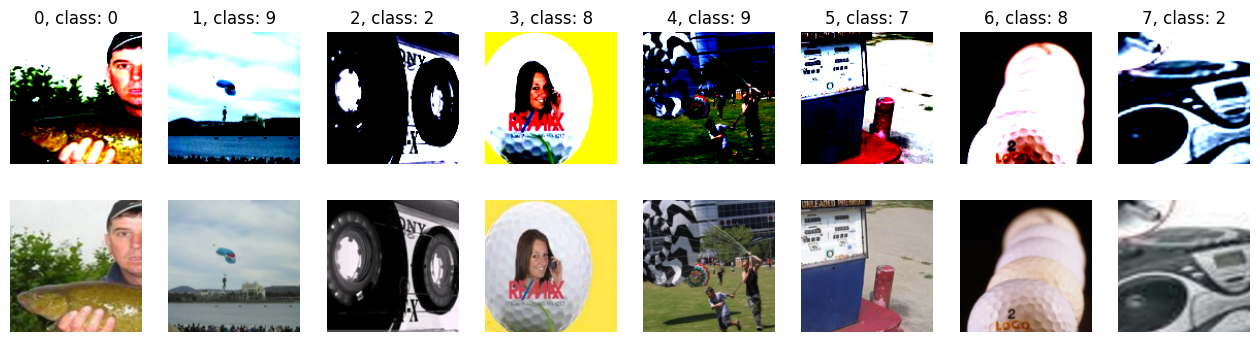

In [12]:
# Plot some training images next to 5 vizualisation images
n = 8
fig, ax = plt.subplots(2, n, figsize=(n*2, 4))
for i in range(n):
    ax[0, i].imshow(batch[0][i].permute(1, 2, 0).cpu().numpy())
    ax[1, i].imshow(viz_batch[0][i].permute(1, 2, 0).cpu().numpy())
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[0, i].set_title(f"{i}, class: {batch[1][i]}")

In [13]:
# During dev/debugging, choose one image from above to use
image_index = 4

In [14]:
# Check input and output shapes and types (images and labels)
print("images:", batch[0].shape, batch[0].dtype)
print("labels:", batch[1].shape, batch[1].dtype)

images: torch.Size([128, 3, 128, 128]) torch.float32
labels: torch.Size([128]) torch.int64


## Auxiliary saliency maps
Auxiliary saliency maps for explanation methods at three different validation set accuracies. Displaying also the true label.

In [27]:
use_true_labels = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


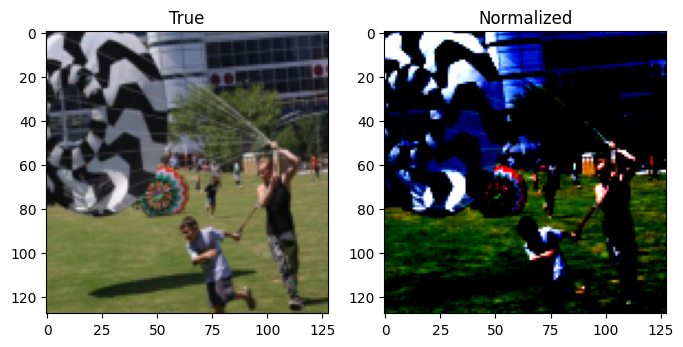

In [32]:
length = 10
torch.manual_seed(seed)
temp = next(iter(val_acc_loader))
images_to_explain = temp[0].cuda()[:length]
true_labels = temp[1].cuda()[:length]
# predictions = model(images_to_explain)
# labels = predictions.argmax(dim=1)[:length]

torch.manual_seed(seed)
viz_images_to_explain = next(iter(viz_loader))[0][:length]
# plt.imshow(images_to_explain[image_index].permute(1,2,0).cpu().numpy())
# plt.show()

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].set_title("True")
axes[0].imshow(viz_images_to_explain[image_index].permute(1,2,0).cpu().numpy())
axes[1].set_title("Normalized")
axes[1].imshow(images_to_explain[image_index].permute(1,2,0).cpu().numpy())
figure.show()

In [19]:

torch.manual_seed(seed)
temp = next(iter(val_acc_loader))
images_to_explain = temp[0].cuda()[:length]
torch.manual_seed(seed)
viz_images_to_explain = next(iter(viz_loader))[0][:length]

model = None
gc.collect()
torch.cuda.empty_cache()
model = xse_resnext50(n_out=10, act_cls=nn.Mish, sa=1, sym=0, pool=MaxPool).to(device)
criterion = LabelSmoothingCrossEntropy()
optimizer = ranger(model.parameters(), LR, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0)
done = False
current_batch = 1
tr_counter = 0
acc_attr = dict()
if use_true_labels: labels_to_explain = temp[1].cuda()[:length]
else: labels_to_explain = model(images_to_explain).argmax(dim=1)[:length]
model_predictions = dict()

for epoch in range(NUM_EPOCHS):
    if done: break
    model.train()
    
    start = time.time()
    losses = AverageMeter("Loss", ":.4e")
    top1 = AverageMeter("Acc@1", ":6.2f")
    
    for i, (images, labels) in enumerate(train_loader):
        if done: break
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True) # non-blocking here with a single GPU will likely do nothing
            labels = labels.cuda(non_blocking=True) # non-blocking here makes sense - we can start
                                                        # doing something else before labels are needed
        # compute output
        output = model(images)
        loss = criterion(output, labels)
        
        # measure accuracy and record loss
        losses.update(loss.item(), images.size(0))
        acc1 = accuracy(output, labels, topk=(1,))
        top1.update(acc1[0].item(), images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        new_lr = lr_schedule(current_batch / (NUM_EPOCHS * len(train_loader)))
        optimizer.set_hyper("lr", new_lr)
        current_batch += 1
    
        tr_counter += len(images)
        if tr_counter >= 1000:
            tr_counter = 0
            model.eval()        # TODO cleanup?

            val_losses = AverageMeter("Loss", ":.4e")
            val_top1 = AverageMeter("Acc@1", ":6.2f")
            with torch.no_grad():
                for i, (images, labels) in enumerate(val_acc_loader):
                    if torch.cuda.is_available():
                        images = images.cuda(non_blocking=True)
                        labels = labels.cuda(non_blocking=True)

                    # compute output
                    output = model(images)
                    loss = criterion(output, labels)

                    # measure accuracy and record loss
                    val_losses.update(loss.item(), images.size(0))
                    acc1 = accuracy(output, labels, topk=(1,))
                    val_top1.update(acc1[0].item(), images.size(0))
                
            if val_top1.avg >= 50:
                done = True
                acc_attr.update({val_top1.avg : generate_attributions(model, images_to_explain, labels_to_explain, 2, next(iter(val_acc_loader))[0].cuda())})
                model_predictions.update({val_top1.avg : model(images_to_explain).argmax(dim=1)})
    # measure elapsed time
    end = time.time()
    elapsed = end - start
    
    print(f"{epoch+1}: * TrainLoss {losses.avg:.3f}  * TrainAcc@1 {top1.avg:.3f}  * ValLoss {val_losses.avg:.3f}  \
            * ValAcc@1 {val_top1.avg:.3f}  * Time {elapsed:.2f}")


model = xse_resnext50(n_out=10, act_cls=nn.Mish, sa=1, sym=0, pool=MaxPool).to(device)
model.eval()        # TODO cleanup?
val_losses = AverageMeter("Loss", ":.4e")
val_top1 = AverageMeter("Acc@1", ":6.2f")
with torch.no_grad():
    for i, (images, labels) in enumerate(val_acc_loader):
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        # compute output
        output = model(images)
        loss = criterion(output, labels)
        # measure accuracy and record loss
        val_losses.update(loss.item(), images.size(0))
        acc1 = accuracy(output, labels, topk=(1,))
        val_top1.update(acc1[0].item(), images.size(0))

acc_attr.update({val_top1.avg : generate_attributions(model, images_to_explain, labels_to_explain, 2, next(iter(val_acc_loader))[0].cuda())})
model_predictions.update({val_top1.avg : model(images_to_explain).argmax(dim=1)})


model.load_state_dict(torch.load("./xse_resnext50_10_82.752_0.931.pth", map_location=torch.device(device)))
model.eval()        # TODO cleanup?
val_losses = AverageMeter("Loss", ":.4e")
val_top1 = AverageMeter("Acc@1", ":6.2f")
with torch.no_grad():
    for i, (images, labels) in enumerate(val_acc_loader):
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        # compute output
        output = model(images)
        loss = criterion(output, labels)
        # measure accuracy and record loss
        val_losses.update(loss.item(), images.size(0))
        acc1 = accuracy(output, labels, topk=(1,))
        val_top1.update(acc1[0].item(), images.size(0))

acc_attr.update({val_top1.avg : generate_attributions(model, images_to_explain, labels_to_explain, 2, next(iter(val_acc_loader))[0].cuda())})
model_predictions.update({val_top1.avg : model(images_to_explain).argmax(dim=1)})


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/anaconda/envs/azur

1: * TrainLoss 2.026  * TrainAcc@1 32.717  * ValLoss 1.737              * ValAcc@1 48.000  * Time 100.25
2: * TrainLoss 1.895  * TrainAcc@1 44.056  * ValLoss 1.628              * ValAcc@1 52.051  * Time 74.73


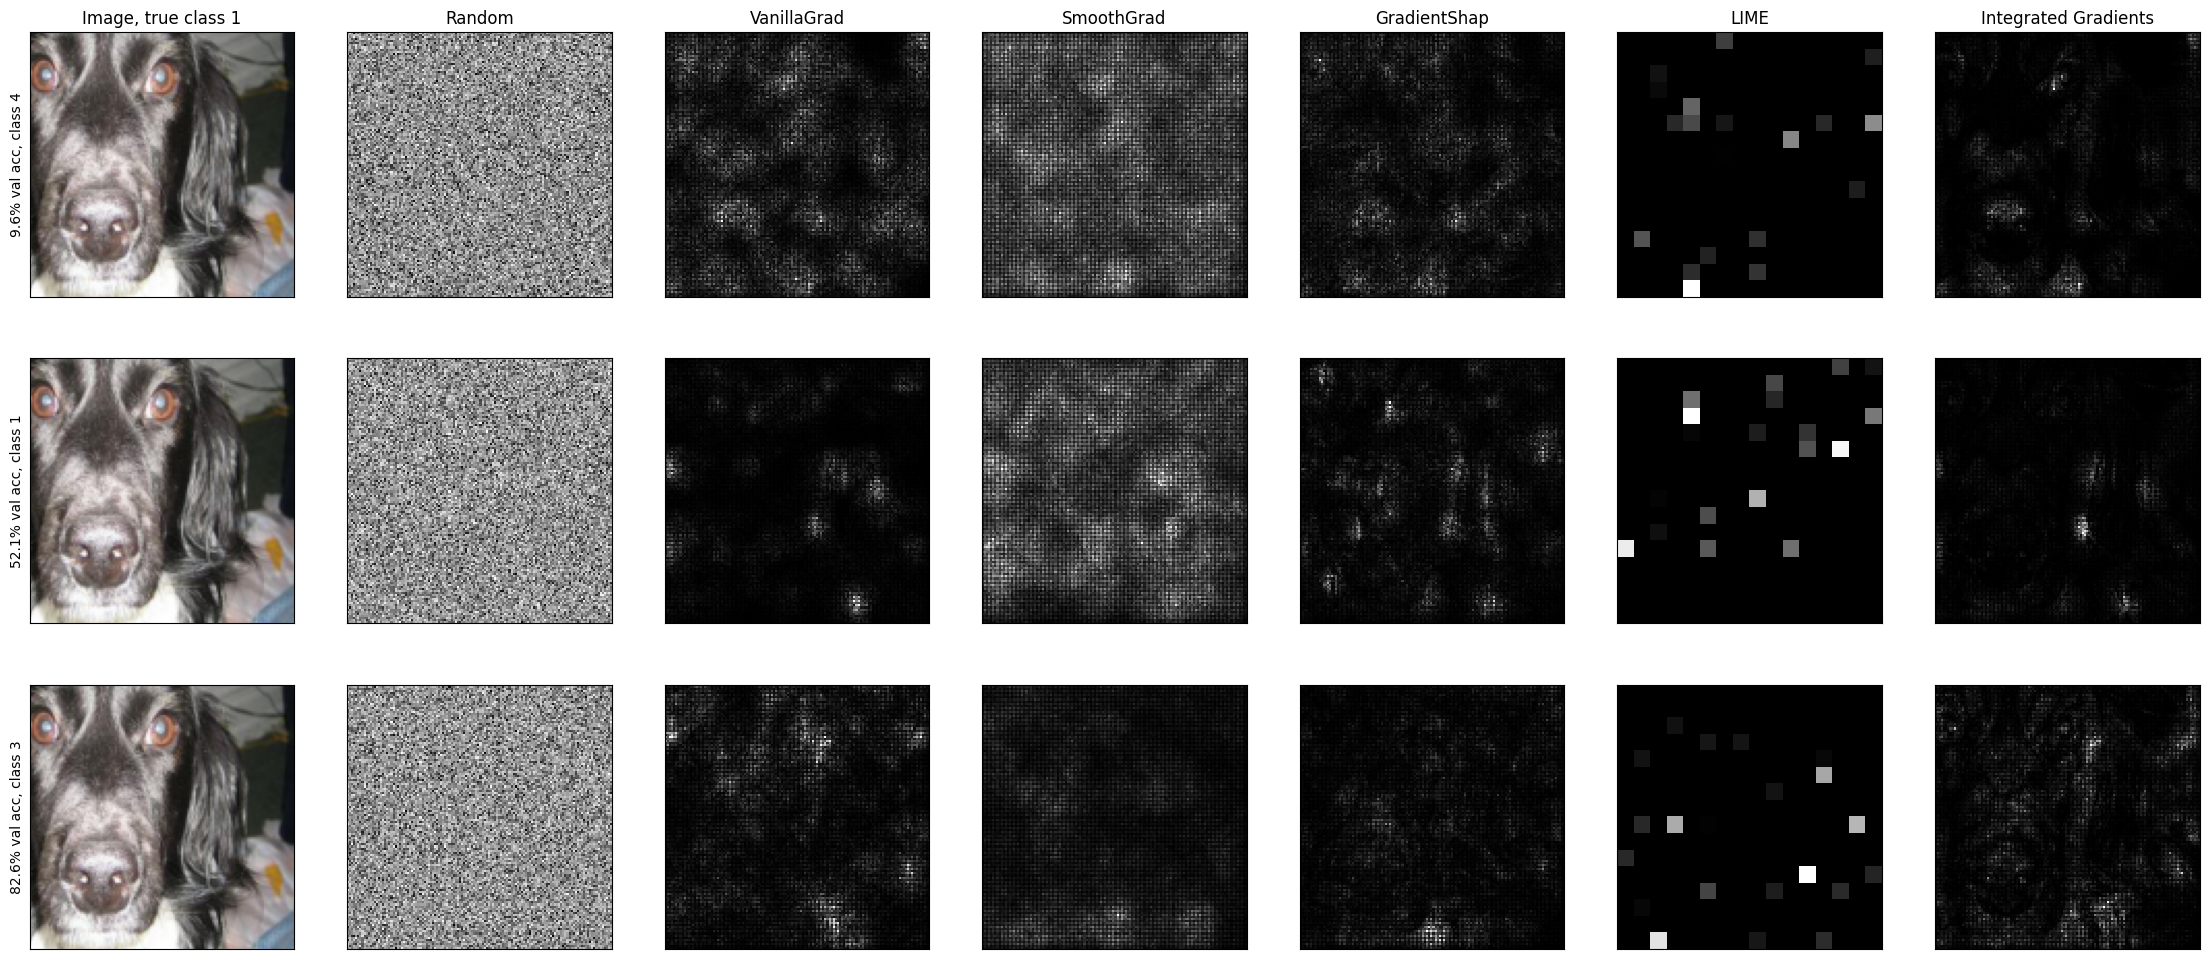

In [20]:
methods = ["Random", "VanillaGrad", "SmoothGrad", "GradientShap", "LIME", "Integrated Gradients"]
rows = 3
image_index=9
torch.manual_seed(seed)
temp = next(iter(val_acc_loader))
chosen_image_true_label = temp[1].cuda()[image_index]

cols = len(methods) + 1
figure, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*4,rows*4))
axes[0, 0].set_title(f"Image, true class {chosen_image_true_label}")

for i, (acc, attr) in enumerate(acc_attr.items()):
    if (acc < 45): i = 0
    if (45 < acc and acc < 75): i = 1
    if (75 < acc): i = 2
    axes[i, 0].imshow(viz_images_to_explain[image_index].permute(1, 2, 0).cpu().numpy())
    
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    if use_true_labels:
        axes[i, 0].set_ylabel(f"{acc:.1f}% val acc, class {chosen_image_true_label}")
    else:
        axes[i, 0].set_ylabel(f"{acc:.1f}% val acc, class {model_predictions[acc][image_index]}")

    for method in range(acc_attr[acc].shape[1]):
        method_name = methods[method]

        # attribution = attributions_acc_true[i][image_index, method].detach().cpu().numpy()
        attribution = acc_attr[acc][image_index, method].detach().cpu().numpy()
        axes[i, 1+method].imshow(attribution, cmap="gray", interpolation="none")
        axes[0, 1+method].set_title(method_name)
        axes[i, 1+method].set_xticks([])
        axes[i, 1+method].set_yticks([])

figure.savefig(f"graphics/png/l2_acc_attr_{use_true_labels}_disp_class.png")#, dpi=300)
figure.show()

# Explanations v4

In [15]:
model = None
measure = None
attributions_list = None
scoring_results = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

In [16]:
print("Running on", device)
model = xse_resnext50(n_out=10, act_cls=nn.Mish, sa=1, sym=0, pool=MaxPool)
model = model.to(device)

criterion = LabelSmoothingCrossEntropy()
optimizer = ranger(model.parameters(), LR, mom=0.95, sqr_mom=0.99, eps=1e-6, beta=0)

Running on cuda


In [17]:
attribution_methods = {}

def attr0(input, labels):
    return torch.rand(input.shape, device=device)

def attr1(input, labels):
    return Saliency(model).attribute(input, target=labels)

def attr2(input, labels):
    return GradientShap(model).attribute(input, next(iter(val_acc_loader))[0].cuda(), target=labels)

# Calculate the number of superpixels along each dimension
num_superpixels = 128 // SUPERPIXEL_SIZE
# Initialize the feature mask tensor with zeros
feature_mask = torch.zeros((128, 128), dtype=torch.int).to(device)
# Assign unique values to each 8x8 block
value = 0
for i in range(num_superpixels):
    for j in range(num_superpixels):
        feature_mask[i*SUPERPIXEL_SIZE:(i+1)*SUPERPIXEL_SIZE, j*SUPERPIXEL_SIZE:(j+1)*SUPERPIXEL_SIZE] = value
        value += 1
def attr3(input, labels):
    return Lime(model).attribute(input, feature_mask=feature_mask, target=labels)

def attr4(input, labels):
    return NoiseTunnel(Saliency(model)).attribute(input, target=labels, nt_type="smoothgrad", nt_samples_batch_size=EXPLANATION_BATCH_SIZE)

def attr5(input, labels):
    return IntegratedGradients(model).attribute(input, target=labels)

# attribution_methods = {"Random": attr0}
attribution_methods = {"Vanillagrad": attr1, "GradientShap": attr2, "LIME": attr3, "SmoothGrad": attr4} #, "IntegratedGradients": attr5}
# attribution_methods = {"IntegratedGradients": attr5}

sufix = "".join(sorted(key[:3] for key in attribution_methods.keys()))
print(sufix)

GraLIMSmoVan


In [18]:
tr_counter = 0
te_counter = 0
current_batch = 1

accuracy_summary_score_pairs = []
accuracy_auxiliary_pairs = []
auxiliary = True

In [19]:
for epoch in range(NUM_EPOCHS):
    model.train()
    
    start = time.time()
    now = start
    losses = AverageMeter("Loss", ":.4e")
    top1 = AverageMeter("Acc@1", ":6.2f")
    
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True) # non-blocking here with a single GPU will likely do nothing
            labels = labels.cuda(non_blocking=True) # non-blocking here makes sense - we can start
                                                    # doing something else before labels are needed
        output = model(images)
        loss = criterion(output, labels)
        
        losses.update(loss.item(), images.size(0))
        acc1 = accuracy(output, labels, topk=(1,))
        top1.update(acc1[0].item(), images.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        new_lr = lr_schedule(current_batch / (NUM_EPOCHS * len(train_loader)))
        optimizer.set_hyper("lr", new_lr)
        current_batch += 1
    
        tr_counter += len(images)
        if tr_counter >= START_TEST_FREQUENCY + te_counter * STEP_TEST_FREQUENCY:
            tr_counter = 0
            te_counter += 1
            model.eval()        # TODO cleanup?
            if auxiliary:
                method_sums = sum_explanations(model, val_test_loader, attribution_methods)
            else:
                res = average_summary_scores(model, val_test_loader, EXPLANATION_BATCH_SIZE, attribution_methods, ["IAUC", "DAUC"])

            temp = 0
            val_losses = AverageMeter("Loss", ":.4e")
            val_top1 = AverageMeter("Acc@1", ":6.2f")
            with torch.no_grad():
                for i, (images, labels) in enumerate(val_acc_loader):
                    if torch.cuda.is_available():
                        images = images.cuda(non_blocking=True)
                        labels = labels.cuda(non_blocking=True)

                    # compute output
                    output = model(images)
                    probs = F.softmax(output, dim=1)
                    temp += torch.sum(probs * torch.log(probs))     # sum over all classes and entire batch
                    loss = criterion(output, labels)

                    # measure accuracy and record loss
                    val_losses.update(loss.item(), images.size(0))
                    acc1 = accuracy(output, labels, topk=(1,))
                    val_top1.update(acc1[0].item(), images.size(0))

            entropy = temp / len(val_acc_loader.dataset)
            
            # measure elapsed time
            temp = now
            now = time.time()
            elapsed = now - temp
            
            if auxiliary:
                print(f"Epoch {epoch+1}.{te_counter} * TrLoss {losses.avg:.3f}  * TrAcc@1 {top1.avg:2.3f}  * ValLoss {val_losses.avg:.3f} * ValAcc@1 {val_top1.avg:2.3f} * Entropy {entropy} * Time elapsed {elapsed:.2f}")
            else:
                if "Vanillagrad" in attribution_methods:
                    print(f"""{epoch+1}: * TrLoss {losses.avg:.3f}  * TrAcc@1 {top1.avg:2.3f}  * ValLoss {val_losses.avg:.3f} * ValAcc@1 {val_top1.avg:2.3f} * IAUC vanilla {res['IAUC']['Vanillagrad']:.3f} * DAUC vanilla {res['DAUC']['Vanillagrad']:.3f} * Time {elapsed:.2f}""")
                elif "IntegratedGradients" in attribution_methods:
                    print(f"""{epoch+1}: * TrLoss {losses.avg:.3f}  * TrAcc@1 {top1.avg:2.3f}  * ValLoss {val_losses.avg:.3f} * ValAcc@1 {val_top1.avg:2.3f} * IAUC IntegratedGradients {res['IAUC']['IntegratedGradients']:.3f} * DAUC IntegratedGradients {res['DAUC']['IntegratedGradients']:.3f} * Time {elapsed:.2f}""")
                elif "Random" in attribution_methods:
                    print(f"""{epoch+1}: * TrLoss {losses.avg:.3f}  * TrAcc@1 {top1.avg:2.3f}  * ValLoss {val_losses.avg:.3f} * ValAcc@1 {val_top1.avg:2.3f} * IAUC Random {res['IAUC']['Random']:.3f} * DAUC Random {res['DAUC']['Random']:.3f} * Time {elapsed:.2f}""")

            
            if auxiliary:
                accuracy_auxiliary_pairs.append((val_top1.avg, (method_sums, entropy)))
            else:
                accuracy_summary_score_pairs.append((val_top1.avg, res))

            if te_counter % 10 == 0:
                if auxiliary:
                    with open(f"data/no_norm_l2_auxiliary{len(accuracy_auxiliary_pairs)}{sufix}.pkl", "wb") as file:
                        pickle.dump(accuracy_auxiliary_pairs, file)
                else:
                    with open(f"data/no_norm_l2data{len(accuracy_summary_score_pairs)}{sufix}.pkl", "wb") as file:
                            pickle.dump(accuracy_summary_score_pairs, file)

            model.train()
    
    print(f"Time to finish epoch {epoch+1}: {time.time() - start}")

if auxiliary:
    with open(f"data/no_norm_l2_auxiliary{len(accuracy_auxiliary_pairs)}{sufix}.pkl", "wb") as file:
        pickle.dump(accuracy_auxiliary_pairs, file)
else:
    with open(f"data/no_norm_l2data{len(accuracy_summary_score_pairs)}{sufix}.pkl", "wb") as file:
        pickle.dump(accuracy_summary_score_pairs, file)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(
/anaconda/envs/azur

sum_explanations->Vanillagrad:  tensor(5703.9849, device='cuda:0')
Epoch 1.1 * TrLoss 2.347  * TrAcc@1 12.500  * ValLoss 3.019 * ValAcc@1 7.822 * Entropy -1.7285969257354736 * Time elapsed 76.17
sum_explanations->Vanillagrad:  tensor(4461.3433, device='cuda:0')
Epoch 1.2 * TrLoss 2.341  * TrAcc@1 9.766  * ValLoss 2.581 * ValAcc@1 7.414 * Entropy -2.038627862930298 * Time elapsed 74.51
sum_explanations->Vanillagrad:  tensor(4091.0269, device='cuda:0')
Epoch 1.3 * TrLoss 2.325  * TrAcc@1 10.938  * ValLoss 2.428 * ValAcc@1 7.796 * Entropy -2.154588460922241 * Time elapsed 74.76
sum_explanations->Vanillagrad:  tensor(3883.4707, device='cuda:0')
Epoch 1.4 * TrLoss 2.318  * TrAcc@1 11.719  * ValLoss 2.355 * ValAcc@1 10.522 * Entropy -2.204291343688965 * Time elapsed 75.08
sum_explanations->Vanillagrad:  tensor(3312.5173, device='cuda:0')
Epoch 1.5 * TrLoss 2.308  * TrAcc@1 11.719  * ValLoss 2.322 * ValAcc@1 12.178 * Entropy -2.2322518825531006 * Time elapsed 74.99
sum_explanations->Vanillagr

KeyboardInterrupt: 

In [19]:
with open("data/no_norm_l2_auxiliary130Ran.pkl", "rb") as file:
    sum_n_ent_Ran = pickle.load(file)
with open("data/no_norm_l2_auxiliary130GraLIMSmoVan.pkl", "rb") as file:
    sum_n_ent = pickle.load(file)
with open("data/no_norm_l2_auxiliary130Int.pkl", "rb") as file:
    sum_n_ent_ig = pickle.load(file)

print(sum_n_ent_ig)

[(9.095541406133373, ({'IntegratedGradients': tensor(17.0245, device='cuda:0', dtype=torch.float64)}, tensor(-1.8563, device='cuda:0'))), (8.509554159565337, ({'IntegratedGradients': tensor(11.7608, device='cuda:0', dtype=torch.float64)}, tensor(-2.0915, device='cuda:0'))), (9.45222931515639, ({'IntegratedGradients': tensor(9.2843, device='cuda:0', dtype=torch.float64)}, tensor(-2.1874, device='cuda:0'))), (11.388535051285082, ({'IntegratedGradients': tensor(7.0979, device='cuda:0', dtype=torch.float64)}, tensor(-2.2315, device='cuda:0'))), (12.407643316961398, ({'IntegratedGradients': tensor(5.6744, device='cuda:0', dtype=torch.float64)}, tensor(-2.2536, device='cuda:0'))), (14.012738869296518, ({'IntegratedGradients': tensor(5.2072, device='cuda:0', dtype=torch.float64)}, tensor(-2.1810, device='cuda:0'))), (12.891719754941905, ({'IntegratedGradients': tensor(5.3448, device='cuda:0', dtype=torch.float64)}, tensor(-1.8611, device='cuda:0'))), (15.719745235078653, ({'IntegratedGradient

In [20]:
with open("data/no_norm_l2data130Ran.pkl", "rb") as file:
    loaded_data_Ran = pickle.load(file)
with open("data/no_norm_l2data130GraLIMSmoVan.pkl", "rb") as file:
    loaded_data = pickle.load(file)
with open("data/no_norm_l2data130Int.pkl", "rb") as file:
    loaded_data_ig = pickle.load(file)
print(loaded_data)

[(8.968152874138704, {'IAUC': {'Vanillagrad': tensor(0.2555), 'GradientShap': tensor(0.2490), 'LIME': tensor(0.1888), 'SmoothGrad': tensor(0.2472)}, 'DAUC': {'Vanillagrad': tensor(0.1630), 'GradientShap': tensor(0.1677), 'LIME': tensor(0.1698), 'SmoothGrad': tensor(0.1668)}}), (8.407643313316782, {'IAUC': {'Vanillagrad': tensor(0.1607), 'GradientShap': tensor(0.1575), 'LIME': tensor(0.1245), 'SmoothGrad': tensor(0.1549)}, 'DAUC': {'Vanillagrad': tensor(0.1062), 'GradientShap': tensor(0.1101), 'LIME': tensor(0.1153), 'SmoothGrad': tensor(0.1109)}}), (9.757961784046927, {'IAUC': {'Vanillagrad': tensor(0.1263), 'GradientShap': tensor(0.1242), 'LIME': tensor(0.1032), 'SmoothGrad': tensor(0.1257)}, 'DAUC': {'Vanillagrad': tensor(0.0950), 'GradientShap': tensor(0.0985), 'LIME': tensor(0.0980), 'SmoothGrad': tensor(0.1002)}}), (10.649681540811137, {'IAUC': {'Vanillagrad': tensor(0.1231), 'GradientShap': tensor(0.1215), 'LIME': tensor(0.0981), 'SmoothGrad': tensor(0.1253)}, 'DAUC': {'Vanillagr

In [21]:
sorted_data_Ran = sorted(loaded_data_Ran, key=lambda x: x[0])
sorted_data = sorted(loaded_data, key=lambda x: x[0])
sorted_data_ig = sorted(loaded_data_ig, key=lambda x: x[0])
x_values_Ran = [item[0] for item in sorted_data_Ran]
x_values = [item[0] for item in sorted_data]
x_values_ig = [item[0] for item in sorted_data_ig]

for i in range(len(sorted_data)):
    sorted_data_Ran[i][1]["DIFF"] = dict()
    sorted_data[i][1]["DIFF"] = dict()
    sorted_data_ig[i][1]["DIFF"] = dict()
    for method in sorted_data_Ran[i][1]["IAUC"].keys():
        sorted_data_Ran[i][1]["DIFF"][method] = sorted_data_Ran[i][1]["IAUC"][method] - sorted_data_Ran[i][1]["DAUC"][method]
    for method in sorted_data[i][1]["IAUC"].keys():
        sorted_data[i][1]["DIFF"][method] = sorted_data[i][1]["IAUC"][method] - sorted_data[i][1]["DAUC"][method]
    for method in sorted_data_ig[i][1]["IAUC"].keys():
        sorted_data_ig[i][1]["DIFF"][method] = sorted_data_ig[i][1]["IAUC"][method] - sorted_data_ig[i][1]["DAUC"][method]

# And add the DIFF stat for the unsorted data:
for i in range(len(loaded_data)):
    loaded_data_Ran[i][1]["DIFF"] = dict()
    loaded_data[i][1]["DIFF"] = dict()
    loaded_data_ig[i][1]["DIFF"] = dict()
    for method in loaded_data_Ran[i][1]["IAUC"].keys():
        loaded_data_Ran[i][1]["DIFF"][method] = loaded_data_Ran[i][1]["IAUC"][method] - loaded_data_Ran[i][1]["DAUC"][method]
    for method in loaded_data[i][1]["IAUC"].keys():
        loaded_data[i][1]["DIFF"][method] = loaded_data[i][1]["IAUC"][method] - loaded_data[i][1]["DAUC"][method]
    for method in loaded_data_ig[i][1]["IAUC"].keys():
        loaded_data_ig[i][1]["DIFF"][method] = loaded_data_ig[i][1]["IAUC"][method] - loaded_data_ig[i][1]["DAUC"][method]

size=20
alpha=0.6
alpha_scatter = 0.25
alpha_avg = 0.15
window_size = 10

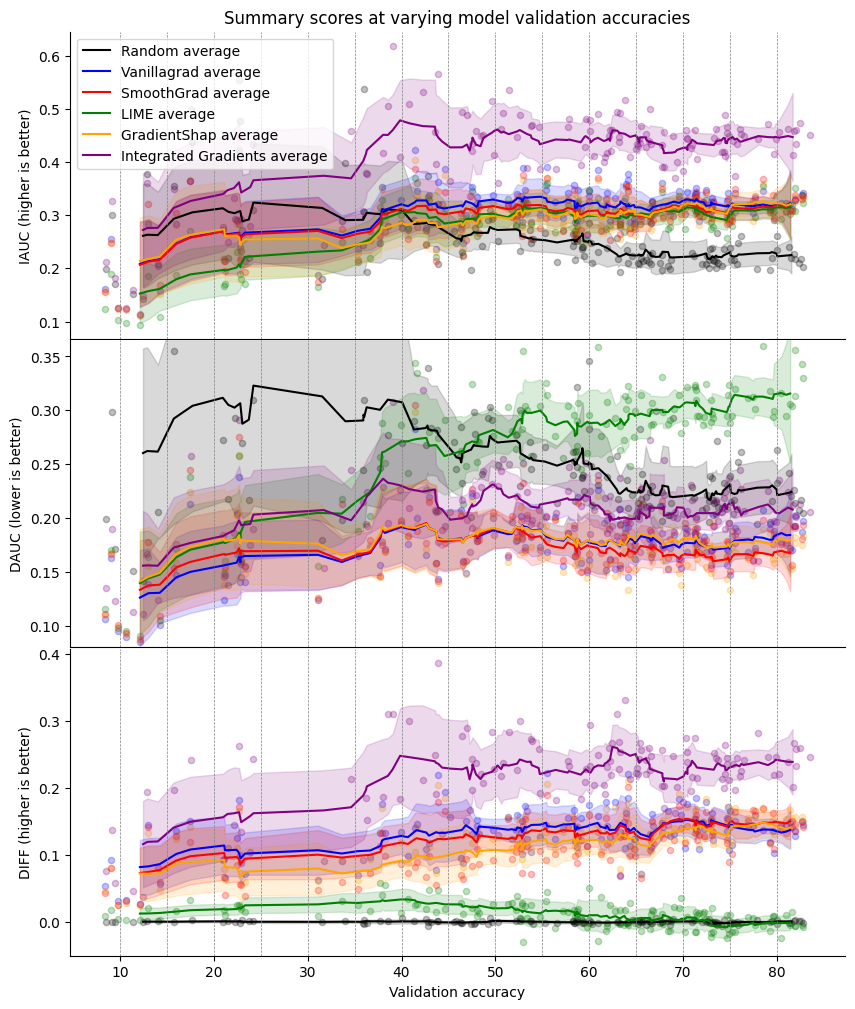

In [26]:
x_values_Ran = [item[0] for item in sorted_data_Ran]
x_values = [item[0] for item in sorted_data]
x_values_ig = [item[0] for item in sorted_data_ig]

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

postfix = [" (higher is better)", " (lower is better)", " (higher is better)"]

for i, stat in enumerate(["IAUC", "DAUC", "DIFF"]):
    random_values = [item[1][stat]["Random"].item() for item in sorted_data_Ran]
    vanillagrad_values = [item[1][stat]["Vanillagrad"].item() for item in sorted_data]
    gradientshap_values = [item[1][stat]["GradientShap"].item() for item in sorted_data]
    lime_values = [item[1][stat]["LIME"].item() for item in sorted_data]
    smoothgrad_values = [item[1][stat]["SmoothGrad"].item() for item in sorted_data]
    integratedgradients_values = [item[1][stat]["IntegratedGradients"].item() for item in sorted_data_ig]

    ra_avg, ra_std = running_stats(random_values, window_size)
    va_avg, va_std = running_stats(vanillagrad_values, window_size)
    sm_avg, sm_std = running_stats(gradientshap_values, window_size)
    li_avg, li_std = running_stats(lime_values, window_size)
    sh_avg, sh_std = running_stats(smoothgrad_values, window_size)
    ig_avg, ig_std = running_stats(integratedgradients_values, window_size)

    x_avg_Ran = x_values_Ran[(window_size-1)//2 : -(window_size//2)]
    x_avg = x_values[(window_size-1)//2 : -(window_size//2)]
    x_avg_ig = x_values_ig[(window_size-1)//2 : -(window_size//2)]

    axs[i].scatter(x_values_Ran, random_values, color="black", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
    axs[i].scatter(x_values, vanillagrad_values, color="blue", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
    axs[i].scatter(x_values, gradientshap_values, color="orange", alpha=alpha_scatter, s=size)#, label="GradientShap")
    axs[i].scatter(x_values, lime_values, color="green", alpha=alpha_scatter, s=size)#, label="LIME")
    axs[i].scatter(x_values, smoothgrad_values, color="red", alpha=alpha_scatter, s=size)#, label="SmoothGrad")
    axs[i].scatter(x_values_ig, integratedgradients_values, color="purple", alpha=alpha_scatter, s=size)#, label="IntegratedGradients")

    axs[i].plot(x_avg_Ran, ra_avg, color="black", label="Random average")
    axs[i].fill_between(x_avg_Ran, ra_avg-ra_std, ra_avg+ra_std, color="black", alpha=alpha_avg)

    axs[i].plot(x_avg, va_avg, color="blue", label="Vanillagrad average")
    axs[i].fill_between(x_avg, va_avg-va_std, va_avg+va_std, color="blue", alpha=alpha_avg)

    axs[i].plot(x_avg, sm_avg, color="red", label="SmoothGrad average")
    axs[i].fill_between(x_avg, sm_avg-sm_std, sm_avg+sm_std, color="red", alpha=alpha_avg)

    axs[i].plot(x_avg, li_avg, color="green", label="LIME average")
    axs[i].fill_between(x_avg, li_avg-li_std, li_avg+li_std, color="green", alpha=alpha_avg)

    axs[i].plot(x_avg, sh_avg, color="orange", label="GradientShap average")
    axs[i].fill_between(x_avg, sh_avg-sh_std, sh_avg+sh_std, color="orange", alpha=alpha_avg)

    axs[i].plot(x_avg_ig, ig_avg, color="purple", label="Integrated Gradients average")
    axs[i].fill_between(x_avg_ig, ig_avg-ig_std, ig_avg+ig_std, color="purple", alpha=alpha_avg)

    # axs[i].xlabel("Validation accuracy")
    axs[i].set_ylabel(stat + postfix[i])

for ax in axs:
    for xc in np.linspace(10, 80, 15):
    # for xc in x_avg[::5]:
        ax.axvline(x=xc, color="gray", linestyle="--", linewidth=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    ax.tick_params(
        axis="x",          # changes apply to the x-axis
        which="both",      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off

axs[1].set_ylim(0.08, 0.365)
axs[2].spines["bottom"].set_visible(True)
axs[2].set_xlabel("Validation accuracy")
axs[2].tick_params(
    axis="x",     
    which="both", 
    bottom=True)
axs[0].legend()
# plt.tight_layout()
fig.subplots_adjust(hspace=0.005)
axs[0].set_title("Summary scores at varying model validation accuracies")
plt.savefig(f"graphics/all{len(x_values)}.svg")

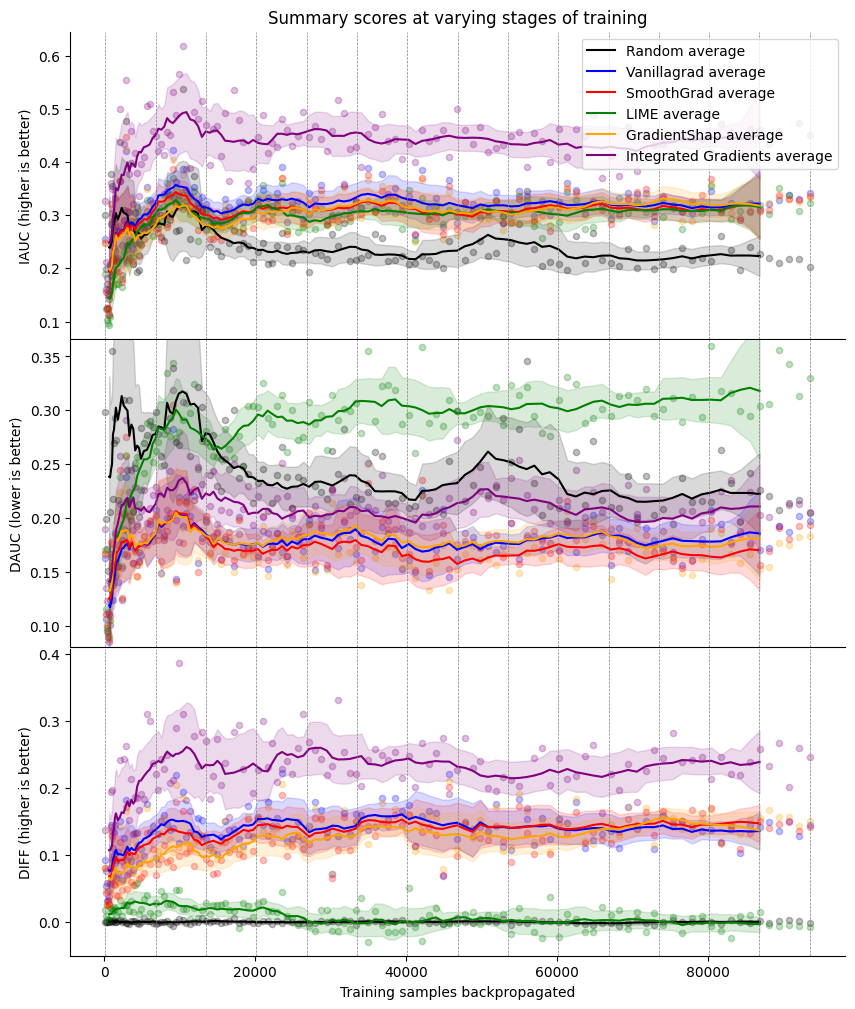

In [23]:
x_values = [] # We don't need separate x values for ig cause they are equal for this metric
counter = 0
tr_counter = 0
te_counter = 0
while te_counter < len(sorted_data):
    tr_counter += BATCH_SIZE
    counter += BATCH_SIZE
    if counter >= START_TEST_FREQUENCY + te_counter * STEP_TEST_FREQUENCY:
        counter = 0
        te_counter += 1
        x_values.append(tr_counter)

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

postfix = [" (higher is better)", " (lower is better)", " (higher is better)"]

for i, stat in enumerate(["IAUC", "DAUC", "DIFF"]):
    random_values = [item[1][stat]["Random"].item() for item in loaded_data_Ran]
    vanillagrad_values = [item[1][stat]["Vanillagrad"].item() for item in loaded_data]
    gradientshap_values = [item[1][stat]["GradientShap"].item() for item in loaded_data]
    lime_values = [item[1][stat]["LIME"].item() for item in loaded_data]
    smoothgrad_values = [item[1][stat]["SmoothGrad"].item() for item in loaded_data]
    integratedgradients_values = [item[1][stat]["IntegratedGradients"].item() for item in loaded_data_ig]

    ra_avg, ra_std = running_stats(random_values, window_size)
    va_avg, va_std = running_stats(vanillagrad_values, window_size)
    sm_avg, sm_std = running_stats(gradientshap_values, window_size)
    li_avg, li_std = running_stats(lime_values, window_size)
    sh_avg, sh_std = running_stats(smoothgrad_values, window_size)
    ig_avg, ig_std = running_stats(integratedgradients_values, window_size)

    x_avg = x_values[(window_size-1)//2 : -(window_size//2)]

    axs[i].scatter(x_values, random_values, color="black", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
    axs[i].scatter(x_values, vanillagrad_values, color="blue", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
    axs[i].scatter(x_values, gradientshap_values, color="orange", alpha=alpha_scatter, s=size)#, label="GradientShap")
    axs[i].scatter(x_values, lime_values, color="green", alpha=alpha_scatter, s=size)#, label="LIME")
    axs[i].scatter(x_values, smoothgrad_values, color="red", alpha=alpha_scatter, s=size)#, label="SmoothGrad")
    axs[i].scatter(x_values, integratedgradients_values, color="purple", alpha=alpha_scatter, s=size)#, label="IntegratedGradients")

    axs[i].plot(x_avg, ra_avg, color="black", label="Random average")
    axs[i].fill_between(x_avg, ra_avg-ra_std, ra_avg+ra_std, color="black", alpha=alpha_avg)

    axs[i].plot(x_avg, va_avg, color="blue", label="Vanillagrad average")
    axs[i].fill_between(x_avg, va_avg-va_std, va_avg+va_std, color="blue", alpha=alpha_avg)

    axs[i].plot(x_avg, sm_avg, color="red", label="SmoothGrad average")
    axs[i].fill_between(x_avg, sm_avg-sm_std, sm_avg+sm_std, color="red", alpha=alpha_avg)

    axs[i].plot(x_avg, li_avg, color="green", label="LIME average")
    axs[i].fill_between(x_avg, li_avg-li_std, li_avg+li_std, color="green", alpha=alpha_avg)

    axs[i].plot(x_avg, sh_avg, color="orange", label="GradientShap average")
    axs[i].fill_between(x_avg, sh_avg-sh_std, sh_avg+sh_std, color="orange", alpha=alpha_avg)

    axs[i].plot(x_avg, ig_avg, color="purple", label="Integrated Gradients average")
    axs[i].fill_between(x_avg, ig_avg-ig_std, ig_avg+ig_std, color="purple", alpha=alpha_avg)

    # axs[i].xlabel("Validation accuracy")
    axs[i].set_ylabel(stat + postfix[i])

for ax in axs:
    for xc in np.linspace(x_values[0], x_values[-1], 15):
    # for xc in x_avg[::5]:
        ax.axvline(x=xc, color="gray", linestyle="--", linewidth=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # ax.spines["left"].set_visible(False)
    # ax.spines["bottom"].set_visible(False)
    ax.tick_params(
        axis="x",          # changes apply to the x-axis
        which="both",      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False)         # ticks along the top edge are off

axs[1].set_ylim(0.08, 0.365)
axs[2].spines["bottom"].set_visible(True)
axs[2].set_xlabel("Training samples backpropagated")
axs[2].tick_params(
    axis="x",     
    which="both", 
    bottom=True)
axs[0].legend()
# plt.tight_layout()
fig.subplots_adjust(hspace=0.005)
axs[0].set_title("Summary scores at varying stages of training")
plt.savefig(f"graphics/all{len(x_values)}_training.svg")

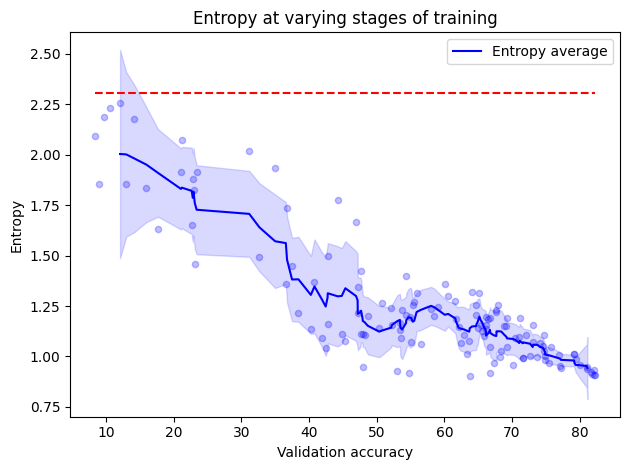

In [24]:
sum_n_ent_Ran = sorted(sum_n_ent_Ran, key=lambda x: x[0])
sum_n_ent = sorted(sum_n_ent, key=lambda x: x[0])
sum_n_ent_ig = sorted(sum_n_ent_ig, key=lambda x: x[0])

acc_Ran = [x[0] for x in sum_n_ent_Ran]
acc = [x[0] for x in sum_n_ent]
acc_ig = [x[0] for x in sum_n_ent_ig]
random_values = [x[1][0]["Random"].cpu()/(128*128) for x in sum_n_ent_Ran]
vanillagrad_values = [x[1][0]["Vanillagrad"].cpu() for x in sum_n_ent]
gradientshap_values = [x[1][0]["GradientShap"].cpu() for x in sum_n_ent]
lime_values = [x[1][0]["LIME"].cpu() for x in sum_n_ent]
smoothgrad_values = [x[1][0]["SmoothGrad"].cpu() for x in sum_n_ent]
integratedgradients_values = [x[1][0]["IntegratedGradients"].cpu() for x in sum_n_ent_ig]
entropy = [-x[1][1].cpu() for x in sum_n_ent]

ra_avg, ra_std = running_stats(random_values, window_size)
va_avg, va_std = running_stats(vanillagrad_values, window_size)
sm_avg, sm_std = running_stats(smoothgrad_values, window_size)
li_avg, li_std = running_stats(lime_values, window_size)
sh_avg, sh_std = running_stats(gradientshap_values, window_size)
ig_avg, ig_std = running_stats(integratedgradients_values, window_size)

x_avg_Ran = acc_Ran[(window_size-1)//2 : -(window_size//2)]
x_avg = acc[(window_size-1)//2 : -(window_size//2)]
x_avg_ig = acc_ig[(window_size-1)//2 : -(window_size//2)]

# Plot accuracy vs sum of explanations
# plt.figure(figsize=(15, 7))

# First plot
# plt.subplot(1, 2, 1)
plt.scatter(acc_Ran, random_values, color="black", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
plt.scatter(acc, vanillagrad_values, color="blue", alpha=alpha_scatter, s=size)#, label="Vanillagrad")
plt.scatter(acc, gradientshap_values, color="orange", alpha=alpha_scatter, s=size)#, label="GradientShap")
plt.scatter(acc, lime_values, color="green", alpha=alpha_scatter, s=size)#, label="LIME")
plt.scatter(acc, smoothgrad_values, color="red", alpha=alpha_scatter, s=size)#, label="SmoothGrad")
plt.scatter(acc_ig, integratedgradients_values, color="purple", alpha=alpha_scatter, s=size)#, label="IntegratedGradients")

plt.plot(x_avg_Ran, ra_avg, color="black", label="Random average (/# pixels)")
plt.fill_between(x_avg_Ran, ra_avg-ra_std, ra_avg+ra_std, color="black", alpha=alpha_avg)

plt.plot(x_avg, va_avg, color="blue", label="Vanillagrad average")
plt.fill_between(x_avg, va_avg-va_std, va_avg+va_std, color="blue", alpha=alpha_avg)

plt.plot(x_avg, sm_avg, color="red", label="SmoothGrad average")
plt.fill_between(x_avg, sm_avg-sm_std, sm_avg+sm_std, color="red", alpha=alpha_avg)

plt.plot(x_avg, li_avg, color="green", label="LIME average")
plt.fill_between(x_avg, li_avg-li_std, li_avg+li_std, color="green", alpha=alpha_avg)

plt.plot(x_avg, sh_avg, color="orange", label="GradientShap average")
plt.fill_between(x_avg, sh_avg-sh_std, sh_avg+sh_std, color="orange", alpha=alpha_avg)

plt.plot(x_avg_ig, ig_avg, color="purple", label="IntegratedGradients average")
plt.fill_between(x_avg, ig_avg-ig_std, ig_avg+ig_std, color="purple", alpha=alpha_avg)

plt.xlabel("Validation accuracy")
plt.ylabel("Sum of explanation")
plt.title("Sum of explanations at varying stages of training")
plt.legend()
plt.savefig(f"graphics/accuracy_vs_explanation_sums{len(acc)}.svg")
plt.clf()



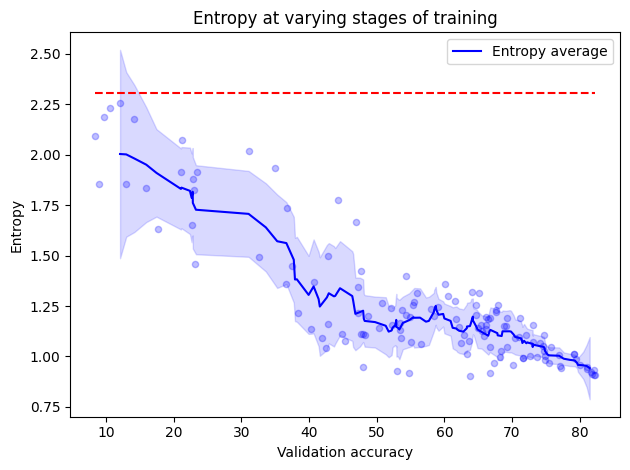

In [33]:

plt.scatter(acc, entropy, color="blue", alpha=alpha_scatter, s=size)#, label="Entropy")

entropy_avg, entropy_std = running_stats(entropy, window_size)
plt.plot(x_avg, entropy_avg, color="blue", label="Entropy average")
plt.fill_between(x_avg, entropy_avg-entropy_std, entropy_avg+entropy_std, color="blue", alpha=alpha_avg)

max_entropy = -np.log(1/10)
plt.hlines(max_entropy, acc[0], acc[-1], linestyles="dashed", color="red")

plt.xlabel("Validation accuracy")
plt.ylabel("Entropy")
plt.title("Entropy at varying stages of training")
plt.legend()

plt.tight_layout()
plt.savefig(f"graphics/entropy{len(acc)}.svg")
plt.show()